In [2]:
# basic imports ===================================================================================
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# data preprocessing ==============================================================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# decision trees & skl imports ====================================================================

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.feature_selection import RFE

# ================================================================================================


# ================================================================================================

# load the data from dataprep

sct_data = pd.read_csv('data/df.csv')

In [3]:
sct_data

,year,gwf_country,ccode,region,ben_impos,ben_threat,ongoing_sanction,inflation,gdpgrowth,log_itpop,...,goldstandard,domestic_debt_in_default,independence,gwf_autocracy,gwf_military,gwf_monarchy,gwf_party,gwf_personal,gwf_democracy,ciri
0,1981,United States,2,Americas,1,1,1,10.378,1.495965,12.352922,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,662.0
1,1982,United States,2,Americas,1,1,0,6.158,-2.811419,12.362315,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,662.0
2,1983,United States,2,Americas,1,1,1,3.160,3.245353,12.371715,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,662.0
3,1984,United States,2,Americas,0,0,1,4.368,6.356311,12.381105,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,662.0
4,1985,United States,2,Americas,1,1,1,3.528,2.955481,12.390475,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,662.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,2016,New Zealand,920,Oceania,0,0,0,1.504,1.779040,8.446556,...,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,479.0
5696,2017,New Zealand,920,Oceania,0,0,0,NaN,1.674501,8.455743,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,479.0
5697,2018,New Zealand,920,Oceania,0,0,0,NaN,0.323606,8.464425,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,479.0
5698,2019,New Zealand,920,Oceania,0,0,0,NaN,-0.659524,8.472823,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,479.0


In [4]:
# Establishing a key of each row per unique ccode and year combination
sct_data['hash_key'] = sct_data['ccode'].astype(str) + sct_data['year'].astype(str)

In [5]:
sct_data['gwf_country'].nunique() # number of countries involved

152

In [6]:
# ================================================================================================

# Popular indicators from Literature (ref) ========================================================

# ================================================================================================

sct_data.columns

Index(['year', 'gwf_country', 'ccode', 'region', 'ben_impos', 'ben_threat',
       'ongoing_sanction', 'inflation', 'gdpgrowth', 'log_itpop', 'region.1',
       'imilex', 'coup', 'coup_lag', 'bankingcrisis', 'systemiccrisis',
       'goldstandard', 'domestic_debt_in_default', 'independence',
       'gwf_autocracy', 'gwf_military', 'gwf_monarchy', 'gwf_party',
       'gwf_personal', 'gwf_democracy', 'ciri', 'hash_key'],
      dtype='object')

In this dataframe, I utilize the TIES v4 Dataset (ref) in the creation of two variables "ben_impos" and "ben_threat" in which the imposition, and threat of a sanction can be sufficiently measured per country, per year. Both variables are binary, and do not account for the amount of sanctions as they are often multilateral in nature. 

Variables of Interest:

DVs and Identifiers

- id: ("ccode", "year")

DVs:

- ben_impos
- ben_threat


IVs and Controls:

- Human rights score ('ciri') which is categorized into 4 categories
- Inflation %: ("inflation")
- GDP Growth: ("gdpgrowth")
- Population (log): ("log_itpop")
- Region: ("region")
- Regime Type: gwf_autocracy, gwf_military, gwf_monarchy, gwf_party, gwf_personal, gwf_democracy
- Military expenditure (for military-based sanctions): ("imilex")
- Presence of a Coup ("coup") and ("coup_lag")
- Crises
    - Banking Crisis: "bankingcrisis"
    - Systemic Crisis: "systemiccrisis"

<Axes: >

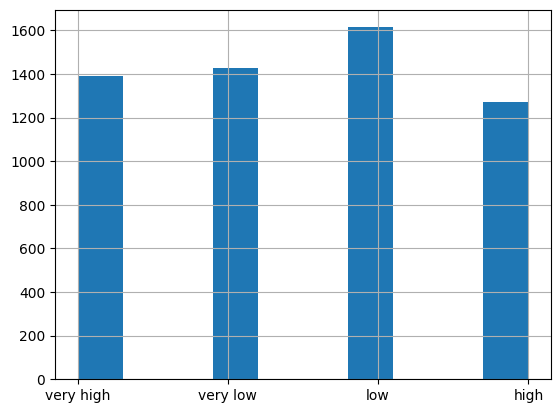

In [7]:
sct_data['ciri'].describe()
sct_data['ciri_cat'] = pd.cut(sct_data['ciri'], bins = 4, labels = ['very low', 'low', 'high', 'very high']) # grouing of "ciri" into 4 categories equally from 101 to 700
sct_data['ciri_cat'].hist()


In [27]:
# number of "ccode" year combinations

data['hash_key'].nunique()

2449

In [8]:
data = sct_data.copy()

In [9]:
data['ciri_cat'].unique()

['very high', 'very low', 'low', 'high']
Categories (4, object): ['very low' < 'low' < 'high' < 'very high']

In [10]:
# Split Data into original TTS

X = data[['ciri_cat', 'inflation', 'gdpgrowth', 'log_itpop', 'region', 'imilex', 'coup', 'coup_lag', 'bankingcrisis', 'systemiccrisis', 'goldstandard', 'domestic_debt_in_default', 'independence', 'gwf_autocracy', 'gwf_military', 'gwf_monarchy', 'gwf_party', 'gwf_personal', 'gwf_democracy']]  # Select relevant features
y = data['ongoing_sanction']  # Select the target variable

In [11]:
label_encoder = LabelEncoder()
data['ciri_cat_encoded'] = label_encoder.fit_transform(data['ciri_cat'])
X['ciri_cat'] = data['ciri_cat_encoded']

C:\Users\Ben\AppData\Local\Temp\ipykernel_11972\2341029483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ciri_cat'] = data['ciri_cat_encoded']


In [12]:
# Categorical Vars

X = pd.get_dummies(X, columns=['region'], drop_first=True)

In [13]:
# Count of values for ongoing_sanction

y.value_counts()

ongoing_sanction
0    4470
1    1230
Name: count, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # Mess around with test size for overfitting


# =========================================== Tree 1: Threat of Sanction =====================================================

tree1 = DecisionTreeClassifier(max_depth=10, random_state=400)
tree1.fit(X_train, y_train)

y_pred = tree1.predict(X_test)
print(classification_report(y_test, y_pred))

### DT Visualization 1 

plt.figure(figsize=(20, 10))
plot_tree(tree1, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1568
           1       0.35      0.25      0.29       142

    accuracy                           0.90      1710
   macro avg       0.64      0.61      0.62      1710
weighted avg       0.89      0.90      0.89      1710



KeyboardInterrupt: 

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


c:\Users\Ben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
625 fits failed out of a total of 3750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
625 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Ben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

best params: {'class_weight': {0: 1, 1: 3}, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1568
           1       0.30      0.42      0.35       142

    accuracy                           0.87      1710
   macro avg       0.62      0.67      0.64      1710
weighted avg       0.89      0.87      0.88      1710



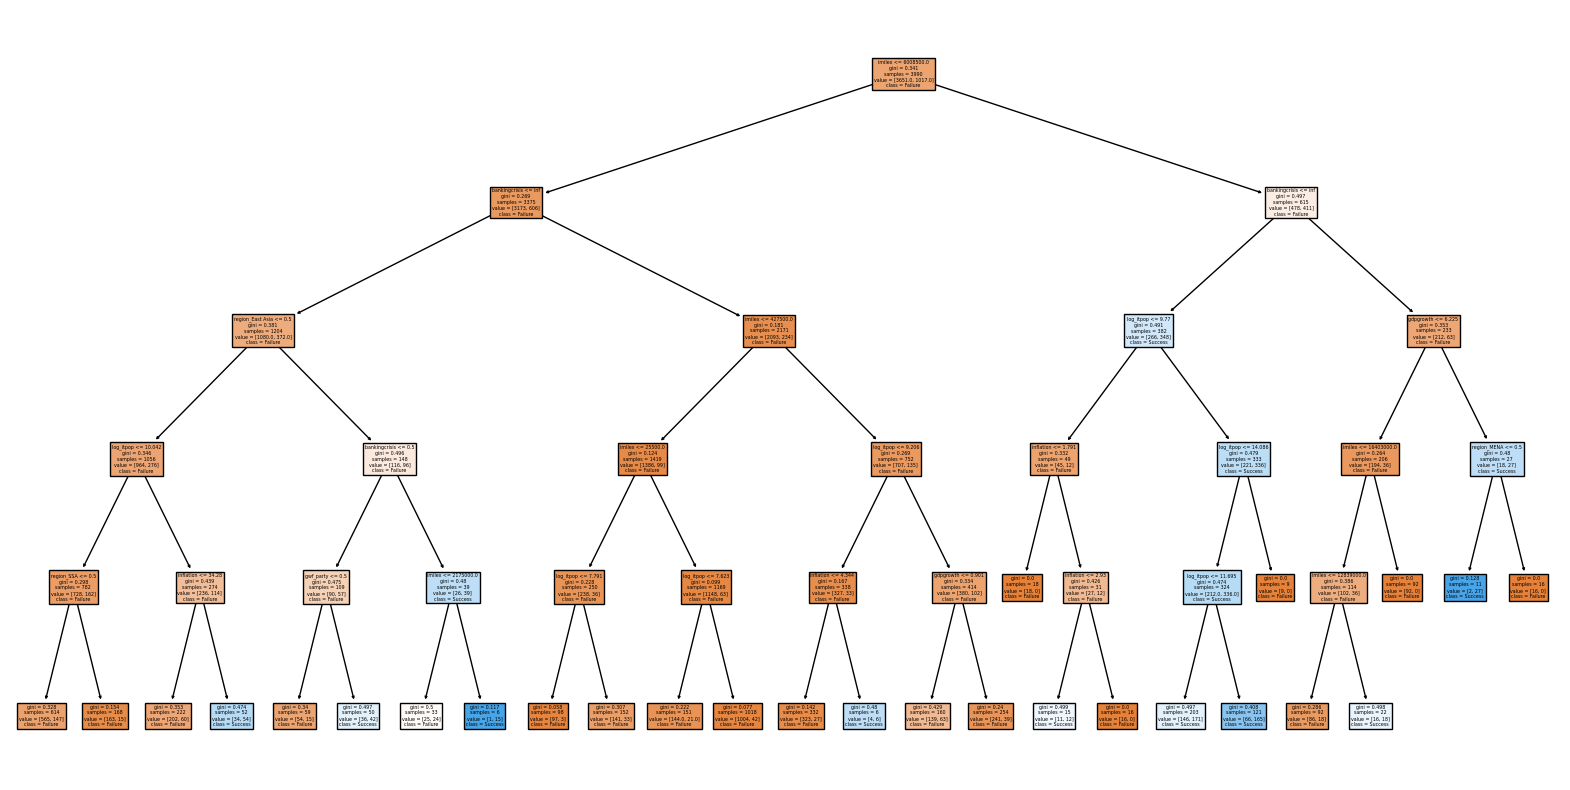

In [30]:
# Finding best params to apply to tree. --------------------------------------------

param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [1, 2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'class_weight': [None, 'balanced', {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 3} ]
}

scorer = make_scorer(f1_score, average='macro')
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=400),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  #5f (#check#)
    verbose=1
)

grid_search.fit(X_train, y_train)
accTree = grid_search.best_estimator_
print("best params:", grid_search.best_params_)

y_predAcc = accTree.predict(X_test)
print(classification_report(y_test, y_predAcc))

plt.figure(figsize=(20, 10))
plot_tree(accTree, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()


In [16]:

rfe = RFE(estimator=DecisionTreeClassifier(random_state=400), n_features_to_select=7)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

accTree_rfe = DecisionTreeClassifier(random_state=400)
accTree_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = accTree_rfe.predict(X_test_rfe)

# Evaluate the reduced model
print(classification_report(y_test, y_pred_rfe)) # goal here is find most important features, see if it performs better for simply testing


Selected features: Index(['ciri_cat', 'inflation', 'gdpgrowth', 'log_itpop', 'imilex',
       'gwf_party', 'region_SSA'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1340
           1       0.59      0.58      0.58       370

    accuracy                           0.82      1710
   macro avg       0.73      0.73      0.73      1710
weighted avg       0.82      0.82      0.82      1710



              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1595
           1       0.33      0.17      0.22       115

    accuracy                           0.92      1710
   macro avg       0.64      0.57      0.59      1710
weighted avg       0.90      0.92      0.91      1710



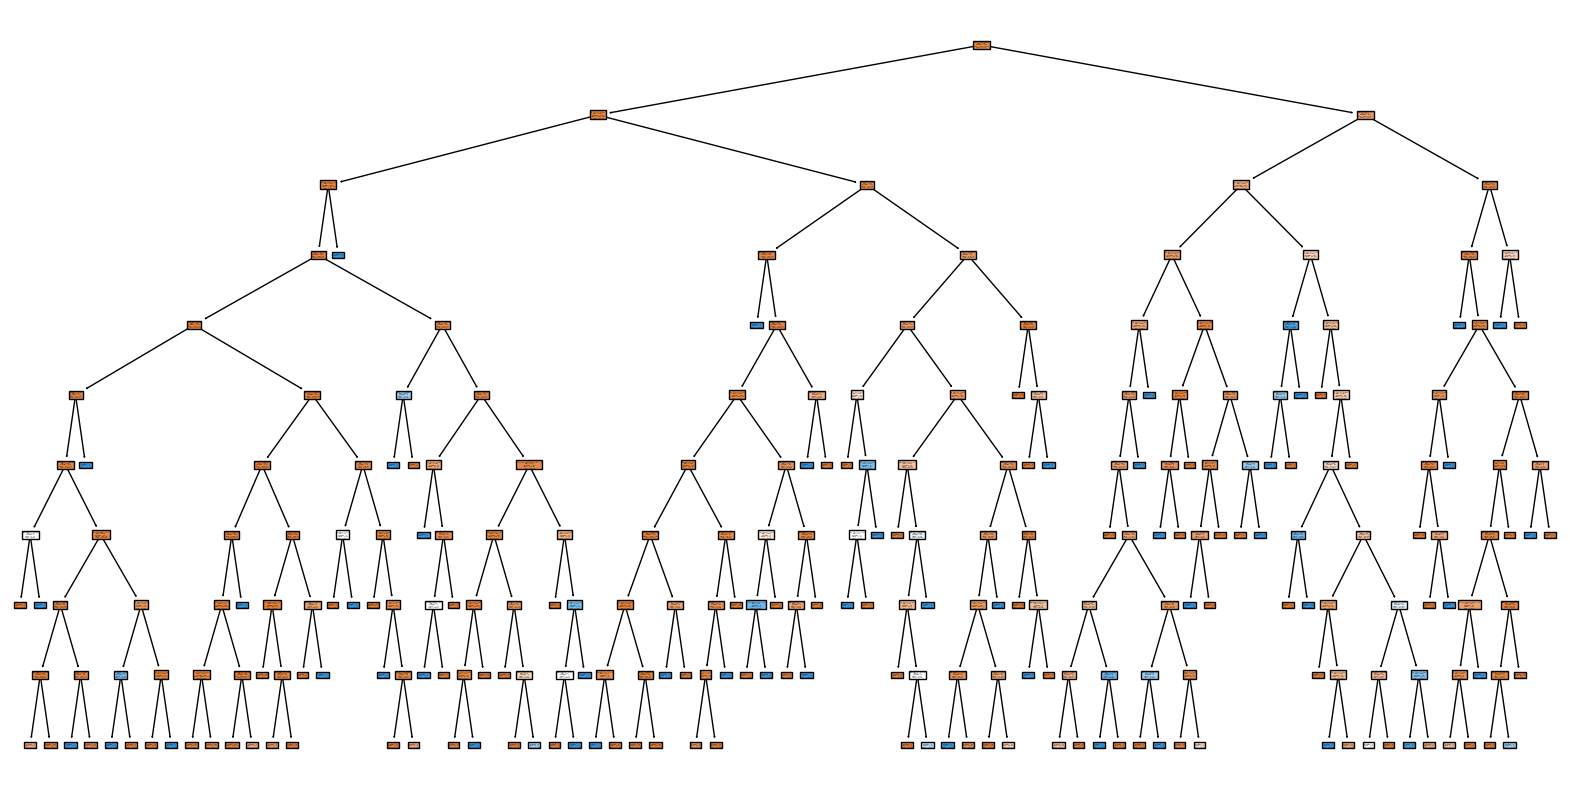

In [17]:
# =========================================== OUTDATED Tree 2: Imposition of Sanction =================================================

y = data['ben_impos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # Mess around with test size for overfitting

tree2 = DecisionTreeClassifier(max_depth=10, random_state=400)
tree2.fit(X_train, y_train)

y_pred = tree2.predict(X_test)
print(classification_report(y_test, y_pred))

### dt vis 2  

plt.figure(figsize=(20, 10))
plot_tree(tree2, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'class_weight': None, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1595
           1       0.32      0.24      0.28       115

    accuracy                           0.91      1710
   macro avg       0.63      0.60      0.62      1710
weighted avg       0.90      0.91      0.91      1710



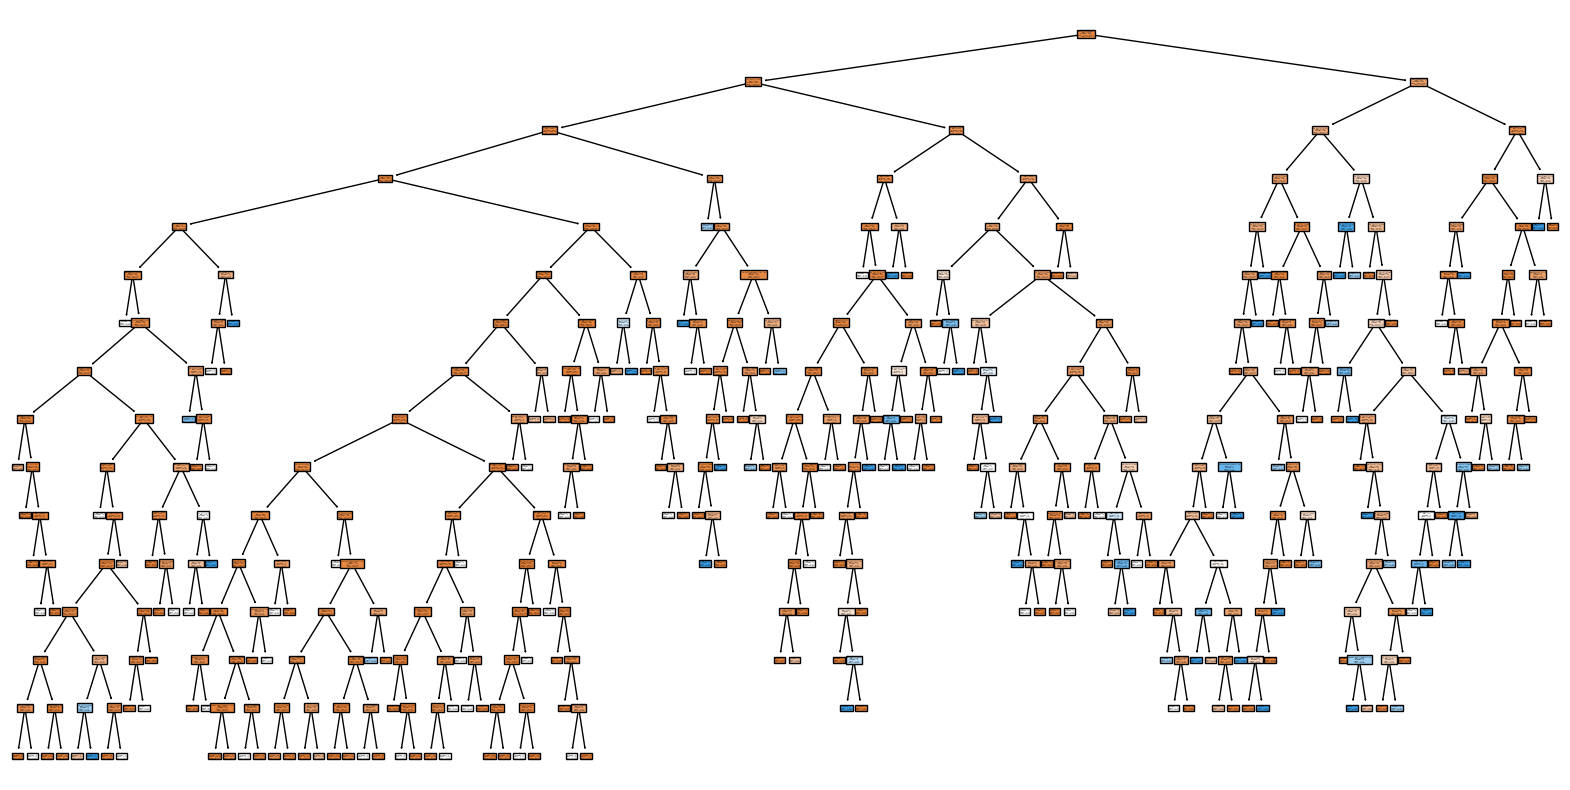

In [18]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', {0: 1, 1: 4}, {0: 1, 1: 5}]
}
scorer = make_scorer(f1_score, average='macro')  # Use F1-macro to balance precision and recall

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=400),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
y_pred_best = best_tree.predict(X_test)
print(classification_report(y_test, y_pred_best))
####################
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()


              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1568
           1       0.35      0.25      0.29       142

    accuracy                           0.90      1710
   macro avg       0.64      0.61      0.62      1710
weighted avg       0.89      0.90      0.89      1710



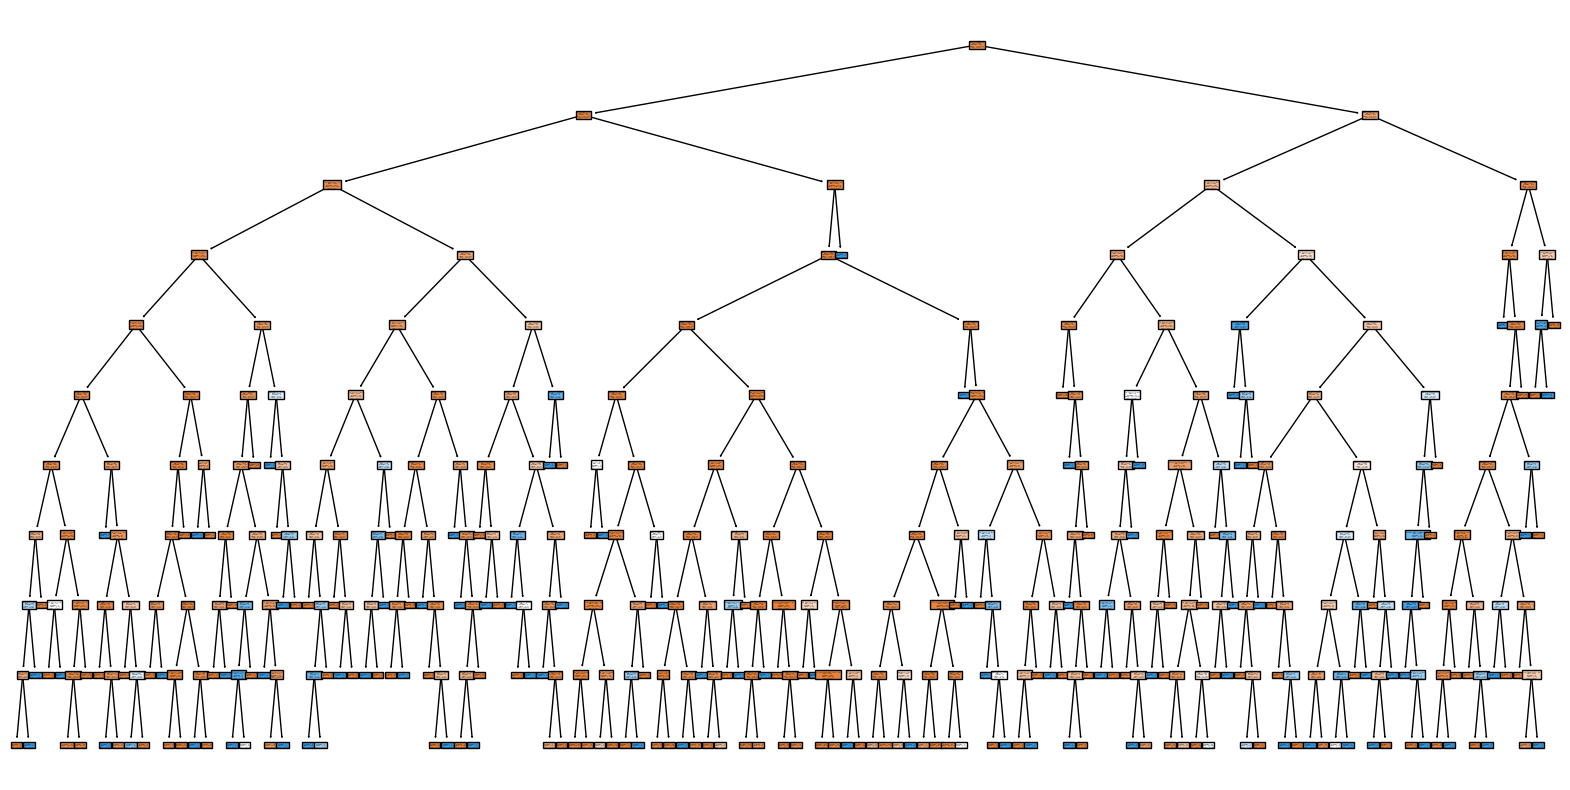

In [19]:
# =========================================== Tree 3: Threat of Sanction ====================================================

y = data['ben_threat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # Mess around with test size for overfitting

tree3 = DecisionTreeClassifier(max_depth=10, random_state=400)
tree3.fit(X_train, y_train)

y_pred = tree3.predict(X_test)
print(classification_report(y_test, y_pred))

### DT Visualization 3 

plt.figure(figsize=(20, 10))
plot_tree(tree3, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'class_weight': {0: 1, 1: 4}, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1568
           1       0.26      0.43      0.32       142

    accuracy                           0.85      1710
   macro avg       0.60      0.66      0.62      1710
weighted avg       0.89      0.85      0.87      1710



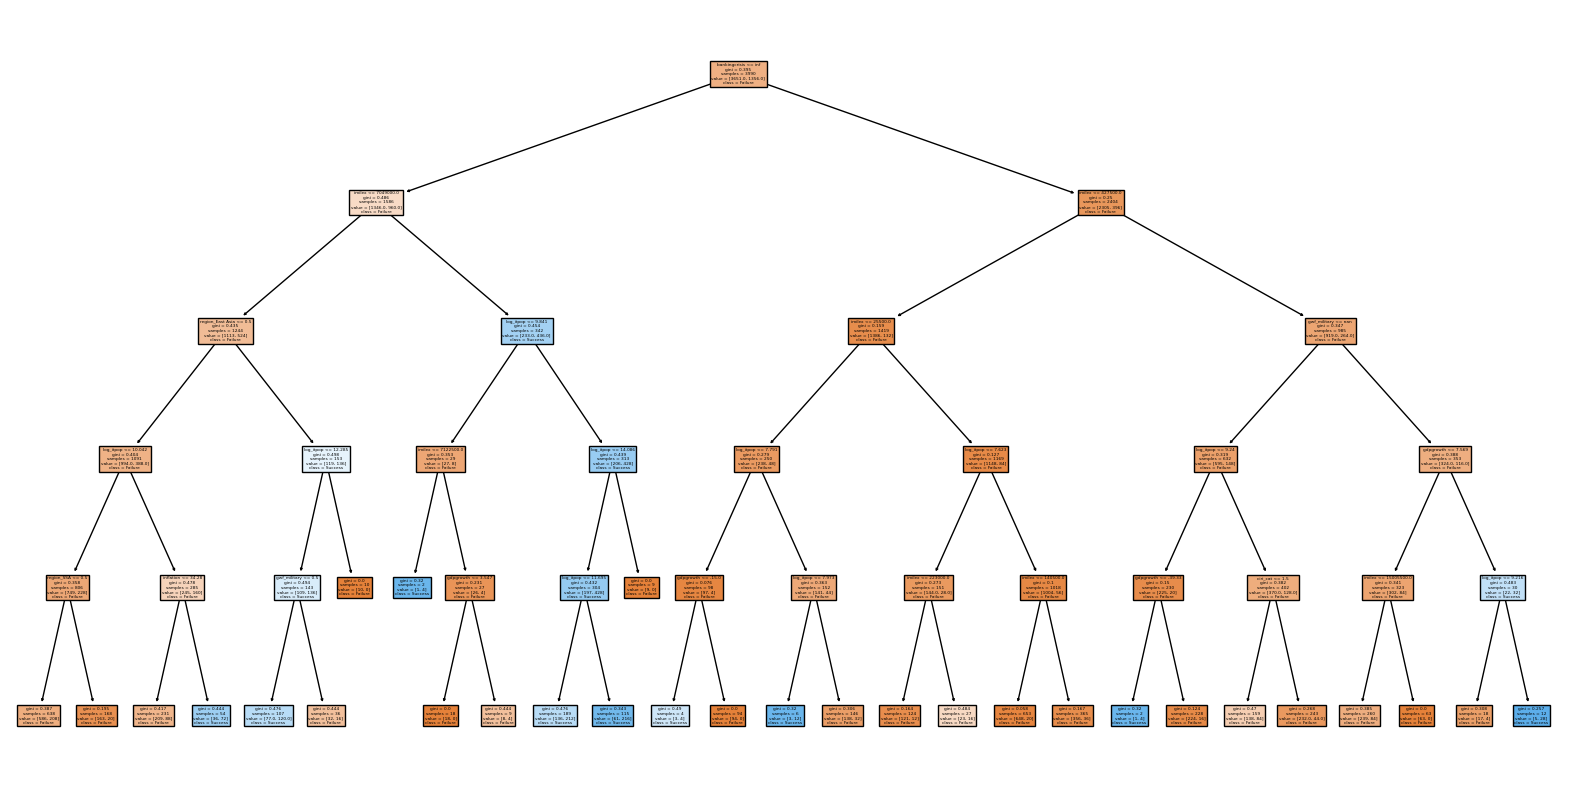

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', {0: 1, 1: 4}, {0: 1, 1: 5}]
}
scorer = make_scorer(f1_score, average='macro')  # Use F1-macro to balance precision and recall
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=400),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
y_pred_best = best_tree.predict(X_test)
print(classification_report(y_test, y_pred_best))

plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True)
plt.show()


In [21]:
data['year'].describe()

count    5700.000000
mean     2001.103158
std        11.383714
min      1981.000000
25%      1992.000000
50%      2001.000000
75%      2011.000000
max      2020.000000
Name: year, dtype: float64

In [22]:
data['bankingcrisis'] = data['bankingcrisis'].fillna(0)
data['systemiccrisis'] = data['systemiccrisis'].fillna(0)
data = data.drop(['goldstandard', 'domestic_debt_in_default', 'independence'], axis=1)
data = data.dropna()

In [23]:
data

,year,gwf_country,ccode,region,ben_impos,ben_threat,ongoing_sanction,inflation,gdpgrowth,log_itpop,...,gwf_autocracy,gwf_military,gwf_monarchy,gwf_party,gwf_personal,gwf_democracy,ciri,hash_key,ciri_cat,ciri_cat_encoded
0,1981,United States,2,Americas,1,1,1,10.378,1.495965,12.352922,...,0.0,0.0,0.0,0.0,0.0,1.0,662.0,21981,very high,2
1,1982,United States,2,Americas,1,1,0,6.158,-2.811419,12.362315,...,0.0,0.0,0.0,0.0,0.0,1.0,662.0,21982,very high,2
2,1983,United States,2,Americas,1,1,1,3.160,3.245353,12.371715,...,0.0,0.0,0.0,0.0,0.0,1.0,662.0,21983,very high,2
3,1984,United States,2,Americas,0,0,1,4.368,6.356311,12.381105,...,0.0,0.0,0.0,0.0,0.0,1.0,662.0,21984,very high,2
4,1985,United States,2,Americas,1,1,1,3.528,2.955481,12.390475,...,0.0,0.0,0.0,0.0,0.0,1.0,662.0,21985,very high,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,2012,New Zealand,920,Oceania,0,0,0,1.060,-1.051252,8.404696,...,0.0,0.0,0.0,0.0,0.0,1.0,479.0,9202012,high,0
5692,2013,New Zealand,920,Oceania,0,0,0,1.134,3.114754,8.416046,...,0.0,0.0,0.0,0.0,0.0,1.0,479.0,9202013,high,0
5693,2014,New Zealand,920,Oceania,0,0,0,1.228,1.170967,8.426830,...,0.0,0.0,0.0,0.0,0.0,1.0,479.0,9202014,high,0
5694,2015,New Zealand,920,Oceania,0,0,0,0.293,1.069777,8.437067,...,0.0,0.0,0.0,0.0,0.0,1.0,479.0,9202015,high,0


In [24]:
# ccode with ongoing_sanction = 1 in 2010

data[(data['year'] == 2010) & (data['ongoing_sanction'] == 1)]['ccode']

29        2
669     140
1029    211
1457    325
2595    437
3583    552
3663    560
4849    710
5089    750
5329    800
5609    850
Name: ccode, dtype: int64

In [25]:
# How many unique values for ccode

data['ccode'].nunique()

69

# =======================================================
